In [33]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic
from kid_readout.analysis.timeseries import filters

In [72]:
plot_directory = '/home/flanigan/temp/'

In [2]:
npd = npy.NumpyDirectory('/data/readout/2017-11-28_125639_mmw_source.npd/')

In [3]:
print(npd.metadata.script_code)

"""
Measure resonators, one at a time, with the readout tone centered in the filterbank bin.
"""
from __future__ import division
import time


import numpy as np

from kid_readout.roach import analog, calculate, hardware_tools, tools
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware, starcryo_temps
from equipment.srs import lockin
from equipment.custom import mmwave_source
from kid_readout.settings import LOCKIN_SERIAL_PORT

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'mmw_source'
attenuations = [10]
"""
f_center = 1e6 * np.array([
    2757.5,
    #2778.3,
    #2792.0,
    #2816.0,
    #2872.0,  # low Q
    2921.5,
    #2998.5,
    #3001.0,
    3085.0,
    3229.0,
    3316.5,
    #3347.0,
    #3370.5,
    3420.5,
    #3922.0  # no-man's land
    ])
"""
f_center = 1e6 * np.array([3420.5])
fractional_frequency_shift = 0
f_center *= (1 + fractional_frequency_shift)
df_base

In [4]:
npd.node_names()

['SingleSweep0', 'SingleSweepStreamList1', 'ADCSnap2']

In [5]:
coarse = npd.SingleSweep0
sssl = npd.SingleSweepStreamList1
snap = npd.ADCSnap2

In [58]:
coarse.streams[0].roach_state.dac_attenuation

10.0

# ADCSnap

In [49]:
snap.x.ptp(), snap.y.ptp()

(28.0, 28.0)

# Coarse sweep

In [48]:
1e-6 * coarse.resonator.f_0

3420.6198431682592

In [59]:
coarse.resonator.Q_e

(66577.692001594871+32975.189077299088j)

In [60]:
coarse.resonator.Q_i

14410.786936834396

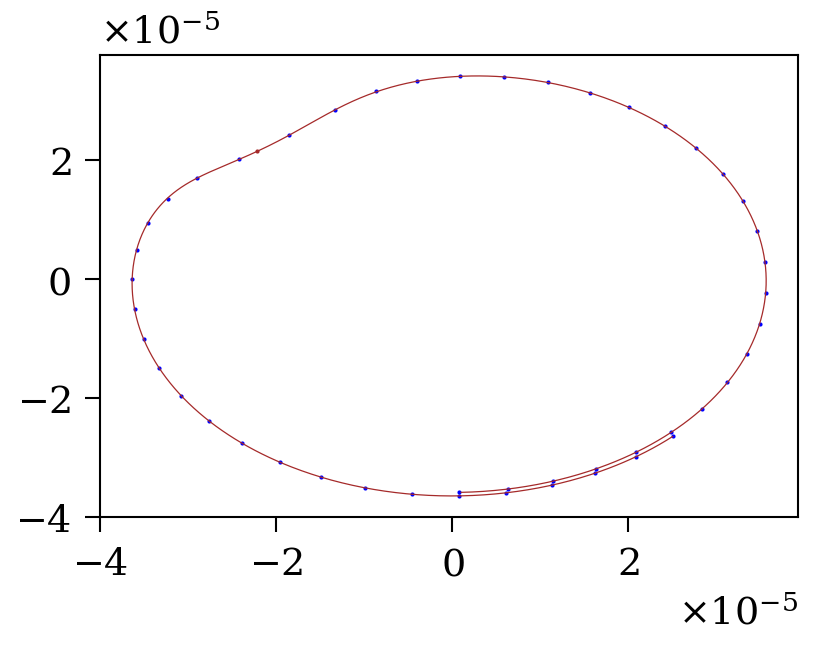

In [6]:
fig, ax = plt.subplots()
plot_basic.resonator_complex_plane(resonator=coarse.resonator, axis=ax, normalize=False);

# Fine sweep and streams

In [14]:
sss_off = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=sssl.stream_list[0], state=sssl.state)
sss_on = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=sssl.stream_list[1], state=sssl.state)

In [27]:
sss_off.stream.state.lockin.rms_voltage

0.00139619

In [30]:
sss_off.stream.roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr18gb_2016_Jun_30_1104.bof', u'modulation_output': 1, u'modulation_rate': 0, u'fft_shift_register': 1048320, u'num_tone_samples': 16384, u'bank': 0, u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 3319120000.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 6.103515625e-05, u'hardware_delay_samples': -16025.6, u'num_tones': 1, u'debug_register': 0, u'reference_sequence_number': 2405627810, u'dac_attenuation': 10.0, u'heterodyne': True})

In [26]:
sss_on.stream.state.lockin.rms_voltage

0.00431827

In [31]:
sss_on.stream.roach_state

StateDict({u'boffile': u'r2iq2xpfb14mcr18gb_2016_Jun_30_1104.bof', u'modulation_output': 2, u'modulation_rate': 7, u'fft_shift_register': 1048320, u'num_tone_samples': 16384, u'bank': 0, u'num_filterbank_channels': 16384, u'loopback': False, u'lo_frequency': 3319120000.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 6.103515625e-05, u'hardware_delay_samples': -16025.6, u'num_tones': 1, u'debug_register': 0, u'reference_sequence_number': 2405627810, u'dac_attenuation': 10.0, u'heterodyne': True})

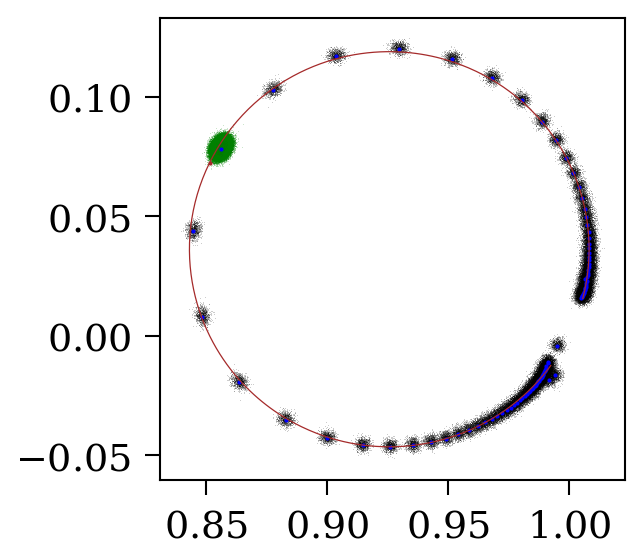

In [23]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.sss_complex_plane(sss=sss_off, axis=ax, normalize=True);

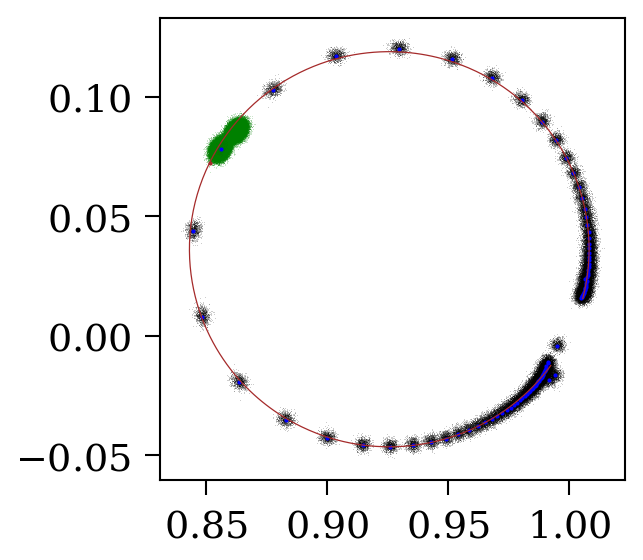

In [24]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.sss_complex_plane(sss=sss_on, axis=ax, normalize=True);

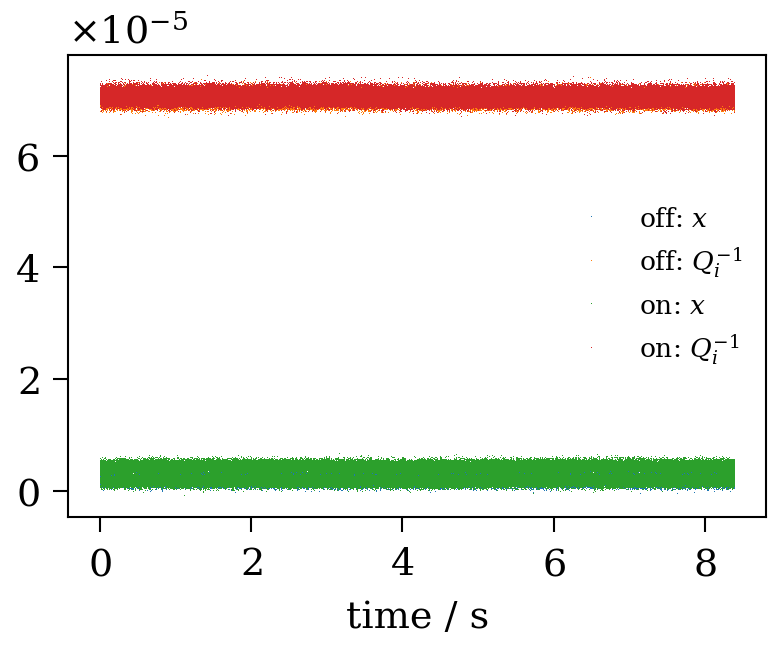

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.plot(sss_off.stream.sample_time, sss_off.x, ',', label='off: $x$')
ax.plot(sss_off.stream.sample_time, sss_off.q, ',', label='off: $Q_i^{-1}$')
ax.plot(sss_on.stream.sample_time, sss_on.x, ',', label='on: $x$')
ax.plot(sss_on.stream.sample_time, sss_on.q, ',', label='on: $Q_i^{-1}$')
ax.legend(fontsize='xx-small');

In [43]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss_on.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

In [44]:
t_off, x_off, q_off = decimate(sss_off)
t_on, x_on, q_on = decimate(sss_on)

(0, 0.1)

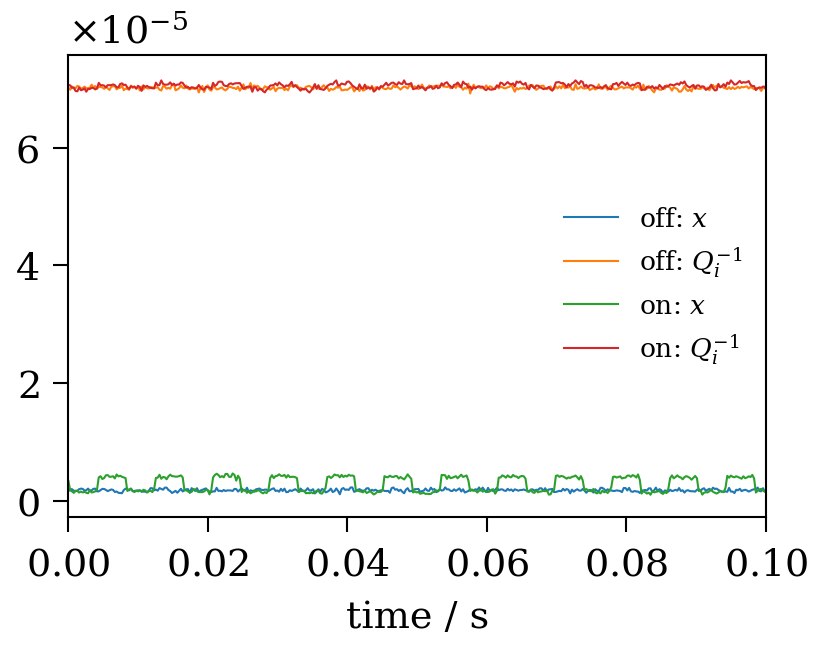

In [47]:
fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.plot(t_off, x_off, '-', label='off: $x$')
ax.plot(t_off, q_off, '-', label='off: $Q_i^{-1}$')
ax.plot(t_on, x_on, '-', label='on: $x$')
ax.plot(t_on, q_on, '-', label='on: $Q_i^{-1}$')
ax.legend(fontsize='xx-small')
ax.set_xlim(0, 0.1)

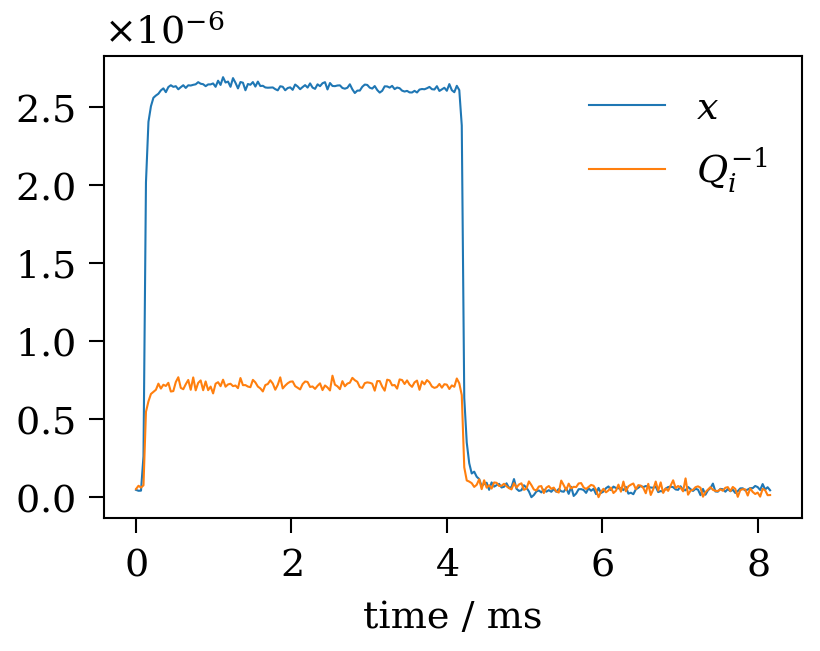

In [57]:
x_fold = sss_on.fold(sss_on.x)
q_fold = sss_on.fold(sss_on.q)
t = np.arange(x_fold.size) / sss_on.stream.stream_sample_rate
fig, ax = plt.subplots()
ax.set_xlabel('time / ms')
ax.plot(1e3 * t, x_fold - x_fold.min(), label='$x$')
ax.plot(1e3 * t, q_fold - q_fold.min(), label='$Q_i^{-1}$')
ax.legend();

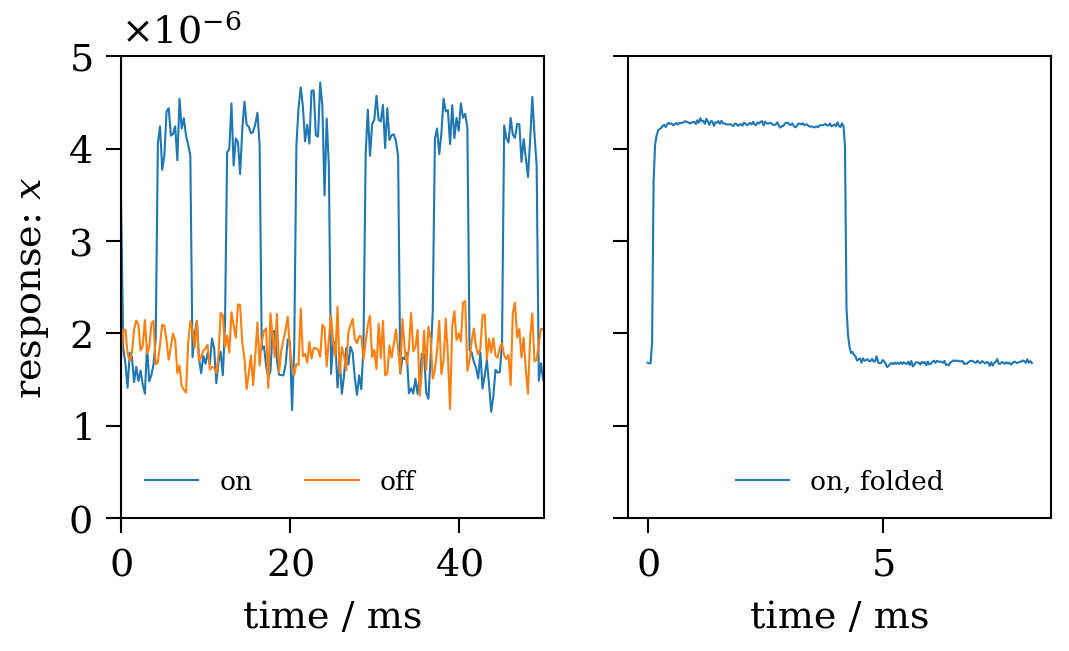

In [74]:
fig, (full_ax, fold_ax) = plt.subplots(1, 2, sharey=True, figsize=(4, 2))
full_ax.set_xlabel('time / ms')
full_ax.set_ylabel('response: $x$')
fold_ax.set_xlabel('time / ms')

full_ax.plot(1e3 * t_on, x_on, '-', label='on')
full_ax.plot(1e3 * t_off, x_off, '-', label='off')
full_ax.legend(fontsize='xx-small', ncol=2)
fold_ax.plot(1e3 * t, x_fold, '-', label='on, folded')
fold_ax.legend(fontsize='xx-small', loc='lower center')
full_ax.set_ylim(0, 5e-6)
full_ax.set_xlim(0, 50)

fig.savefig(plot_directory + 'decimated_and_folded_3421_MHz.pdf')

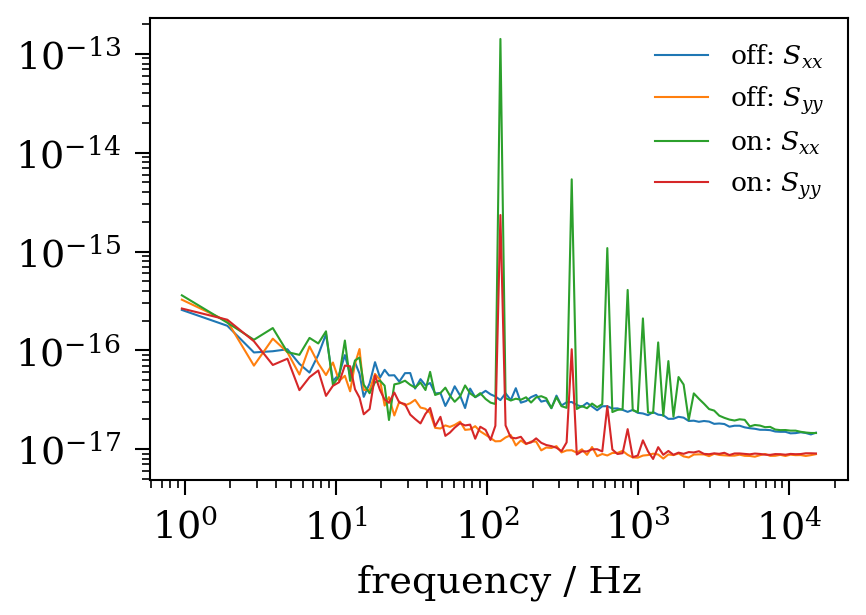

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / Hz')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(sss_off.S_frequency, sss_off.S_xx, label='off: $S_{xx}$')
ax.plot(sss_off.S_frequency, sss_off.S_yy, label='off: $S_{yy}$')
ax.plot(sss_on.S_frequency, sss_on.S_xx, label='on: $S_{xx}$')
ax.plot(sss_on.S_frequency, sss_on.S_yy, label='on: $S_{yy}$')
ax.legend(fontsize='xx-small');